# Airbus Ship Detection Train 2

**Dataset** from [**GitHub**](https://www.kaggle.com/competitions/airbus-ship-detection)

In [1]:
import os
import random

import numpy as np
import pandas as pd

import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split

2023-12-27 13:53:44.928242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 13:53:44.928295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 13:53:44.930077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 13:53:44.940834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 13:53:46.243522: W tensorflow/compiler/tf2tenso

In [2]:
from tensorflow.python.framework.config import set_memory_growth
tf.compat.v1.disable_v2_behavior()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
TRAIN_IMAGES_PATH = 'dataset/train_v2/'
TRAIN_IMAGES_SEGMENTATIONS_PATH = 'dataset/train_ship_segmentations_v2.csv'

VALID_IMAGES_COUNT = 1000
IMAGE_SCALING = (3, 3)
BATCH_SIZE = 20
STEPS_PER_EPOCH = 30
EPOCHS = 2

Utility functions

In [4]:
def load_image(path):
    image = cv2.imread(path)
    image = image[::IMAGE_SCALING[0], ::IMAGE_SCALING[1]]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    if rle_code != rle_code:
        return []
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [
        (pixel_position % 768, pixel_position // 768)
            for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2]))
            for pixel_position in range(start, start + length)
    ]
    return pixels

def create_mask(pixels):
    image = np.zeros((768, 768, 1))
    for x, y in pixels:
        if x < 768 and y < 768:
            image[x, y] = 255
    image = image[::IMAGE_SCALING[0], ::IMAGE_SCALING[1]]
    return image

Loading data

In [5]:
df = pd.read_csv(TRAIN_IMAGES_SEGMENTATIONS_PATH)
df.rename(columns={'ImageId': 'id', 'EncodedPixels': 'mask_rle'}, inplace=True)
df['path'] = [TRAIN_IMAGES_PATH + i for i in df['id'].values]
image_ids = pd.Series(df['id'].unique(), name='id')

In [6]:
train_ids, valid_ids = train_test_split(image_ids, test_size=0.2)
train_data = pd.merge(df, train_ids)
valid_data = pd.merge(df, valid_ids)

Data Augmentation

In [7]:
def augmenting(X, Y):
    '''
    Function for augmenting images. 
    It takes original image and corresponding mask and performs the
    same flipping and rotation transforamtions on both in order to 
    perserve the overlapping of ships and their masks
    '''
    # Add noise:
    x = np.copy(X)
    y = np.copy(Y)
    x[:, :, 0] = x[:, :, 0] + np.random.normal(loc=0.0, scale=0.01, size=(256, 256))
    x[:, :, 1] = x[:, :, 1] + np.random.normal(loc=0.0, scale=0.01, size=(256, 256))
    x[:, :, 2] = x[:, :, 2] + np.random.normal(loc=0.0, scale=0.01, size=(256, 256))

    # Adding Gaussian noise on each rgb channel; this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x < 0)] = 0
    x[np.where(x > 1)] = 1
    
    # Axes swap:
    if np.random.rand() < 0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
        
    # Vertical flip:
    if np.random.rand() < 0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
        
    # Horizontal flip:
    if np.random.rand() < 0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
        
    return x, y

Image generator

In [8]:
def create_batch(data, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 256, 256, 3))
    Y = np.zeros((batch_size, 256, 256, 1)) # I add 1 here to get 4D batch
    for i in range(batch_size):
        sample = data.sample()
        file = sample['path'].values[0]
        mask_pixels = rle_to_pixels(sample['mask_rle'].values[0])
        X[i] = load_image(file) / 255.0 # Pixel normalization
        Y[i] = create_mask(mask_pixels) / 255.0 # Pixel normalization
    return X, Y

def Generator(data, batch_size=BATCH_SIZE):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = create_batch(data, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = augmenting(X[i], Y[i])
        yield X, Y

Metrics and Loss Function

In [9]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = tf.keras.backend.sum(y_true * y_pred, axis=[1, 2, 3])
    Union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - Intersection
    return tf.keras.backend.mean((Intersection + tresh) / (Union + tresh), axis=0)

# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

Building model

In [10]:
inputs = tf.keras.Input((256, 256, 3))

c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2)) (c1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2)) (c2)

c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2)) (c3)

c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = tf.keras.layers.concatenate([u5, c3])
c5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c5)

u6 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = tf.keras.layers.concatenate([u6, c2])
c6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u6)
c6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c6)

u7 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = tf.keras.layers.concatenate([u7, c1], axis=3)
c7 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u7)
c7 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c7)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [11]:
model.compile(optimizer='adam', loss=IoU_loss, metrics=[IoU, back_IoU])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
valid_x, valid_y = next(Generator(valid_data, VALID_IMAGES_COUNT))

Checkpoint callback

In [14]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

Training

In [15]:
history = model.fit(
    Generator(df),
    validation_data=(valid_x, valid_y),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[cp_callback]
)

2023-12-27 13:54:24.778507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1193 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2
2023-12-27 13:54:24.808232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-27 13:54:24.877094: W tensorflow/c/c_api.cc:305] Operation '{name:'total/Assign' id:430 op device:{requested: '', assigned: ''} def:{{{node total/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total, total/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/2


2023-12-27 13:54:26.428068: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:547 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/conv2d_14_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-27 13:54:26.573185: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d/kernel/v/Assign' id:1076 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/kernel/v, training/Adam/conv2d/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Eithe

30/30 [==============================] - ETA: 0s - batch: 14.5000 - size: 20.0000 - loss: 0.9990 - IoU: 9.5173e-04 - back_IoU: 0.5113

/home/mdmvv/.local/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-27 13:54:55.283847: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:547 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/conv2d_14_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: saving model to training/cp.ckpt


2023-12-27 13:55:00.306728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1193 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2


30/30 [==============================] - 36s 697ms/step - batch: 14.5000 - size: 20.0000 - loss: 0.9990 - IoU: 9.5173e-04 - back_IoU: 0.5113 - val_loss: 0.9990 - val_IoU: 9.9663e-04 - val_back_IoU: 0.5238
Epoch 2/2
30/30 [==============================] - ETA: 0s - batch: 14.5000 - size: 20.0000 - loss: 0.9938 - IoU: 0.0062 - back_IoU: 0.6130
Epoch 2: saving model to training/cp.ckpt
30/30 [==============================] - 23s 801ms/step - batch: 14.5000 - size: 20.0000 - loss: 0.9938 - IoU: 0.0062 - back_IoU: 0.6130 - val_loss: 0.9849 - val_IoU: 0.0151 - val_back_IoU: 0.8580


In [16]:
# Save the weights
model.save_weights('weights/weights')

## Prediction

In [17]:
model.load_weights('weights/weights')

In [18]:
import matplotlib.pyplot as plt

In [19]:
PATH = 'ship_images/'

images_data = pd.DataFrame()
images_data['id'] = os.listdir(PATH)
images_data['path'] = [PATH + i for i in images_data['id']]

In [20]:
images = np.zeros((6, 256, 256, 3))
for i in range(6):
    images[i] = load_image(images_data['path'][i]) / 255.0
predictions = model.predict(images)

/home/mdmvv/.local/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-27 13:55:25.663149: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_14/Sigmoid' id:425 op device:{requested: '', assigned: ''} def:{{{node conv2d_14/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_14/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


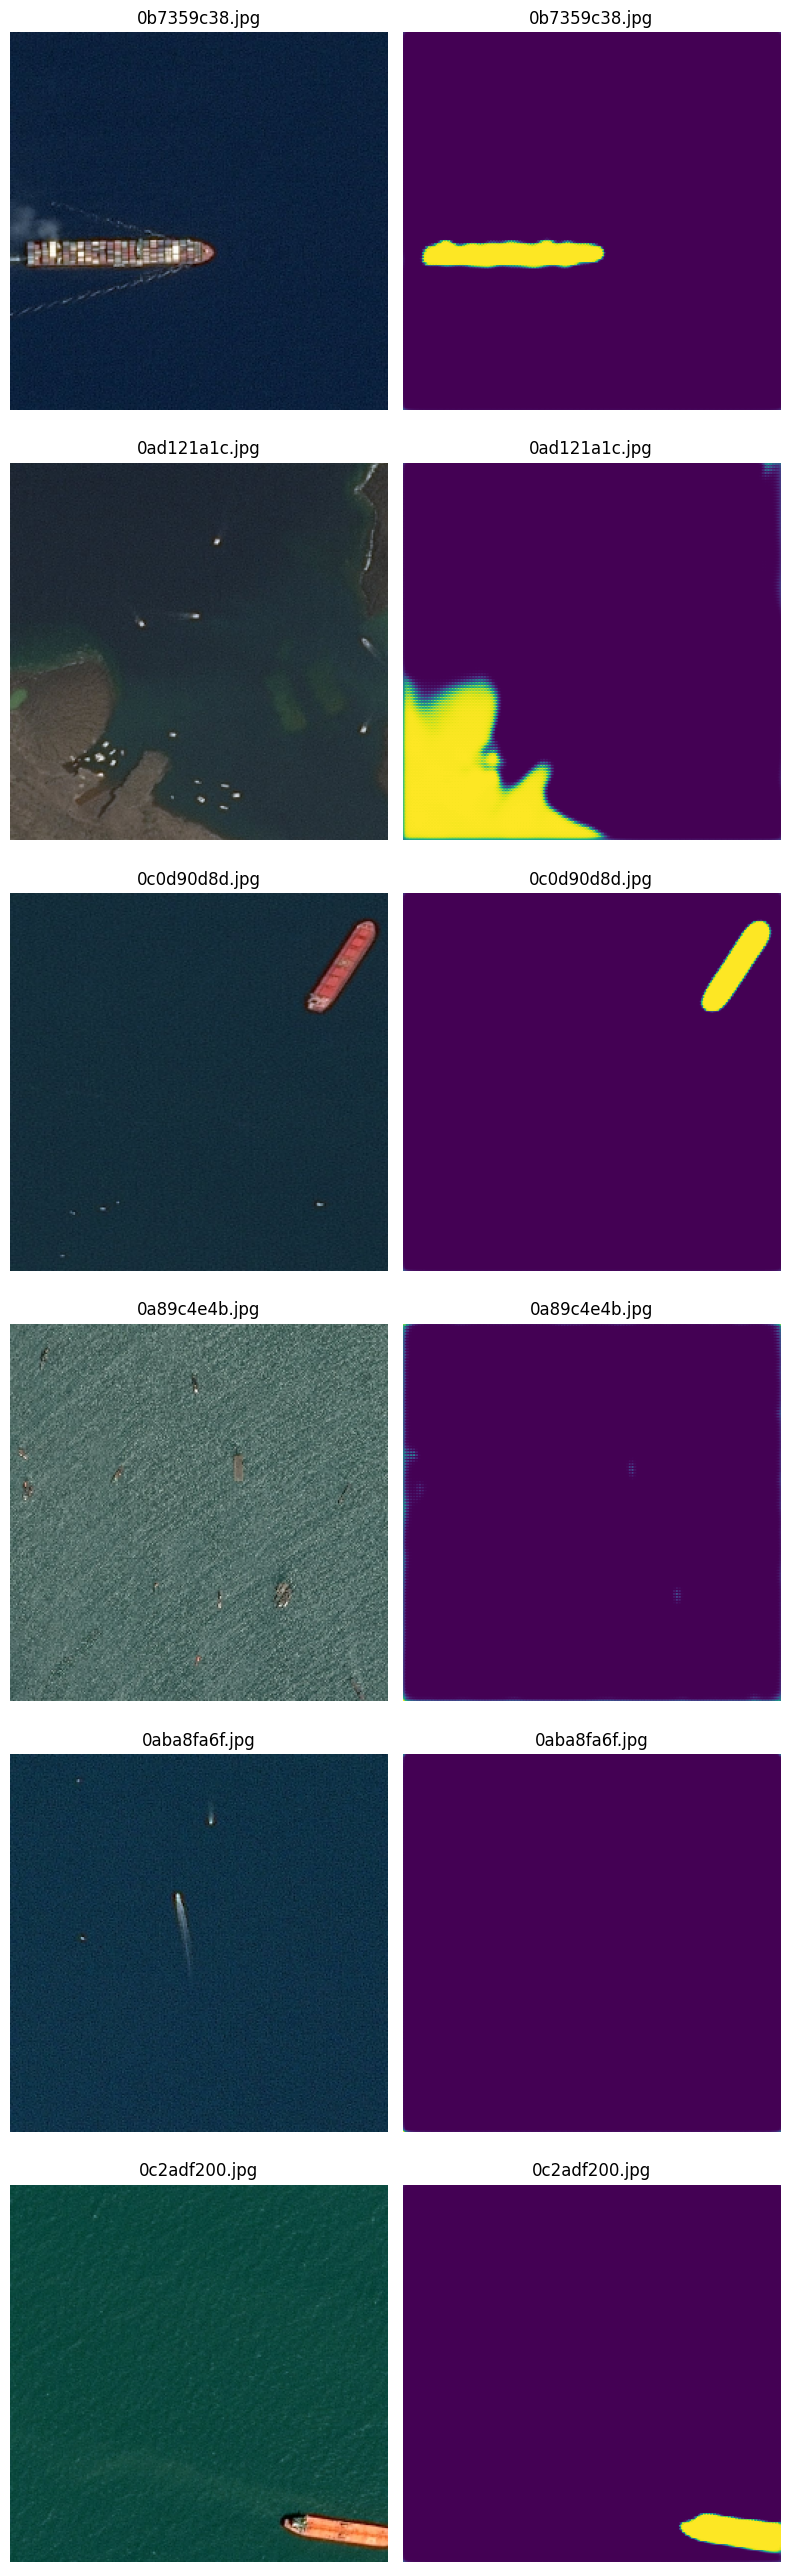

In [21]:
plt.figure(figsize=(8, 26))

for i in range(len(images)):
    plt.subplot(6, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(images_data['id'][i])
    
    plt.subplot(6, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(predictions[i])
    plt.title(images_data['id'][i])
    
plt.tight_layout()
plt.show()